# Variables globales

In [65]:
test_mode = True
verbose = True
import networkx as nx

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.cluster.hierarchy import DisjointSet

In [14]:
m_e = 9.10938356e-31 #en kg
hbar = 1.0545718e-34 #en J.s
E = 1 #en eV

In [68]:
N = 30 # Taille de la grille
a = 1e-7 # Taille de chaque maille élémentaire
sigma = 0.3 #Ecart-type du bruit gaussien
n_el_initial = 100
# Précision de la tension : environ 34 décimales
N_iterations = 500 # Nombre d'itérations par étape
prob_deb = 0.2 # Probabilité de rester dans le début de la grille à chaque initialisation
dropout = 0.3 # Probabilité de disparition des sites
coupe = 0.5 #Permet de cadrer la possibilité pour un électron de sortir de sa case, 0.5 pour rester dans sa case

# Initialisation

In [ ]:
z = np.zeros((N,N,2)) # Deux grilles : l'une suit les abscisses, l'autre les ordonnées
x = np.random.normal(0,sigma/2,size = (N,N))
y = np.random.normal(0,sigma/2,size = (N,N))
x = np.clip(x,-coupe,coupe) #On empêche les points de sortir de leur case
y = np.clip(y,-coupe,coupe) #Idem
bruit = np.stack((x,y),axis=-1) 
z += bruit #Génère le bruit gaussien

electrons = np.full((N,N),fill_value=0) #Trace de la position des électrons à tout instant sur la grille
traces = {i : [] for i in range(n_el_initial)} #Dictionnaire des chemins des électrons à une phase donnée
sites = np.random.choice([0, 1], size=(N, N), p=[dropout, 1 - dropout])
if test_mode:
    sites = np.ones((N, N), dtype = float) #Pas de dropout pour les tests

proj  = np.zeros(N,dtype = float)
for i in range(N):
    if sites[i,0]==1:
        proj[i] = abs(y[i,0])
s = np.sum(proj)
if s > 0:
    proj /= s

In [109]:
def reinitialise():
    """Permet de réinitialiser les paramètres entre deux modélisations"""
    global x,y,z,electrons,bruit,traces, sites, proj
    z = np.zeros((N,N,2)) # Deux grilles : l'une suit les abscisses, l'autre les ordonnées
    x = np.random.normal(0,sigma/2,size = (N,N))
    y = np.random.normal(0,sigma/2,size = (N,N))
    x = np.clip(x,-coupe,coupe) #On empêche les points de sortir de leur case
    y = np.clip(y,-coupe,coupe) #Idem
    bruit = np.stack((x,y),axis=-1) 
    z += bruit #Génère le bruit gaussien

    electrons = np.full((N,N),fill_value=0) #Trace de la position des électrons à tout instant sur la grille
    traces = {i : [] for i in range(n_el_initial)} #Dictionnaire des chemins des électrons à une phase donnée
    sites = np.random.choice([0, 1], size=(N, N), p=[dropout, 1 - dropout])
    if test_mode:
        sites = np.ones((N, N), dtype = float) #Pas de dropout pour les tests
    
    proj  = np.zeros(N,dtype = float)
    for i in range(N):
        if sites[i,0]==1:
            proj[i] = abs(y[i,0])
    s = np.sum(proj)
    if s > 0:
        proj /= s

# Affichage

## Représentation en grille

In [35]:
def affiche_grille(z):
    N,_,_ = z.shape
    plt.xticks(np.arange(0,N,1), labels = [])
    plt.yticks(np.arange(0,N,1), labels = [])
    for i in range(N):
        for j in range(N):
            if sites[i,j]==1:
                xc = i+0.5 + z[i,j,0]
                yc = j+0.5 + z[i,j,1]
                plt.scatter(xc,yc, color = "red")
    plt.grid()

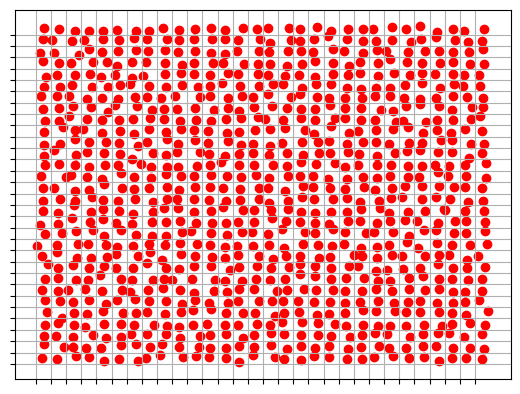

In [36]:
if verbose:
    affiche_grille(z)

In [37]:
def affiche_electrons(electrons):
    fig, ax = plt.subplots()
    N,_ = electrons.shape
    plt.xticks(np.arange(0,N+1,1), labels = [])
    plt.yticks(np.arange(0,N+1,1), labels = [])
    for i in range(N):
        for j in range(N):
            if electrons[i,j]>0:
                rect = patches.Rectangle((i, j), 1, 1, color='black', alpha=0.5) 
                ax.add_patch(rect)           
    plt.grid()

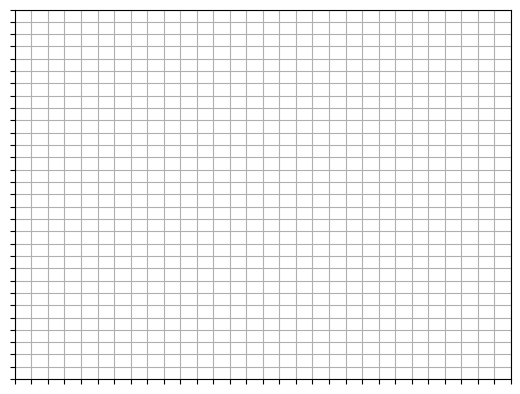

In [38]:
if verbose:
    affiche_electrons(electrons)

In [28]:
def heatmap(electrons):
    """Affiche la carte de chaleur des électrons sur la grille"""
    plt.figure(figsize=(10, 10))
    plt.xticks(ticks=np.arange(electrons.shape[1]), labels=np.arange(electrons.shape[1]))
    plt.yticks(ticks=np.arange(electrons.shape[0]), labels=np.arange(electrons.shape[0]))

    # Tracer la heatmap
    plt.imshow(electrons, cmap=plt.cm.Blues, vmin=1)  # vmin=1 pour que les valeurs 0 soient blanches
    plt.colorbar()  # Ajouter une barre de couleur
    plt.title('Carte des électrons')
    plt.show()

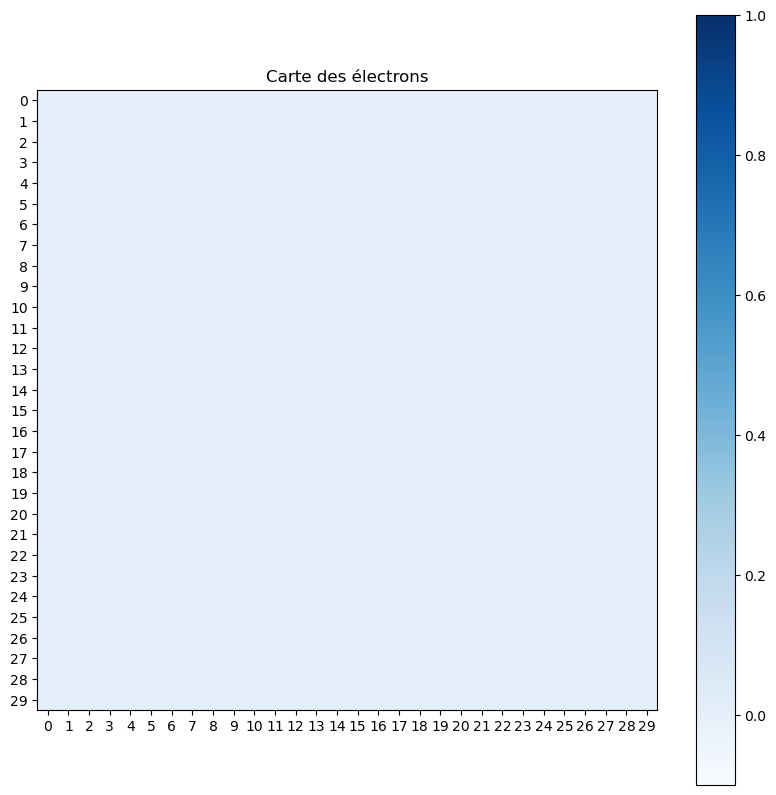

In [39]:
if verbose:
    heatmap(electrons)

## Représentation en graphe

# Initialisation

In [41]:
def first_initialisation():
    global y, n_el_initial, sites, traces, electrons, proj
    """Initialise la position des électrons lors de la première passe"""
    pos = np.random.choice(np.arange(N), size = n_el_initial, p = proj)
    for electron in range(n_el_initial):
        position = pos[electron]
        electrons[position,0] += 1
        traces[electron] = [(position,0)]

Probabilités utilisées: [0.014938   0.02760391 0.05727796 0.02178595 0.05509389 0.02400805
 0.06687667 0.00010525 0.0782497  0.01597678 0.04199011 0.01670599
 0.00425365 0.09174388 0.06431635 0.03483982 0.01774446 0.04568044
 0.03922298 0.02001443 0.00844229 0.01553673 0.02635865 0.05586215
 0.01535129 0.03534279 0.07123484 0.00339569 0.00654569 0.02350161]
Position des électrons : {0: [(np.int64(6), 0)], 1: [(np.int64(18), 0)], 2: [(np.int64(14), 0)], 3: [(np.int64(15), 0)], 4: [(np.int64(18), 0)], 5: [(np.int64(26), 0)], 6: [(np.int64(26), 0)], 7: [(np.int64(17), 0)], 8: [(np.int64(11), 0)], 9: [(np.int64(8), 0)], 10: [(np.int64(19), 0)], 11: [(np.int64(23), 0)], 12: [(np.int64(25), 0)], 13: [(np.int64(15), 0)], 14: [(np.int64(8), 0)], 15: [(np.int64(22), 0)], 16: [(np.int64(13), 0)], 17: [(np.int64(23), 0)], 18: [(np.int64(16), 0)], 19: [(np.int64(13), 0)], 20: [(np.int64(24), 0)], 21: [(np.int64(13), 0)], 22: [(np.int64(1), 0)], 23: [(np.int64(24), 0)], 24: [(np.int64(0), 0)], 25: 

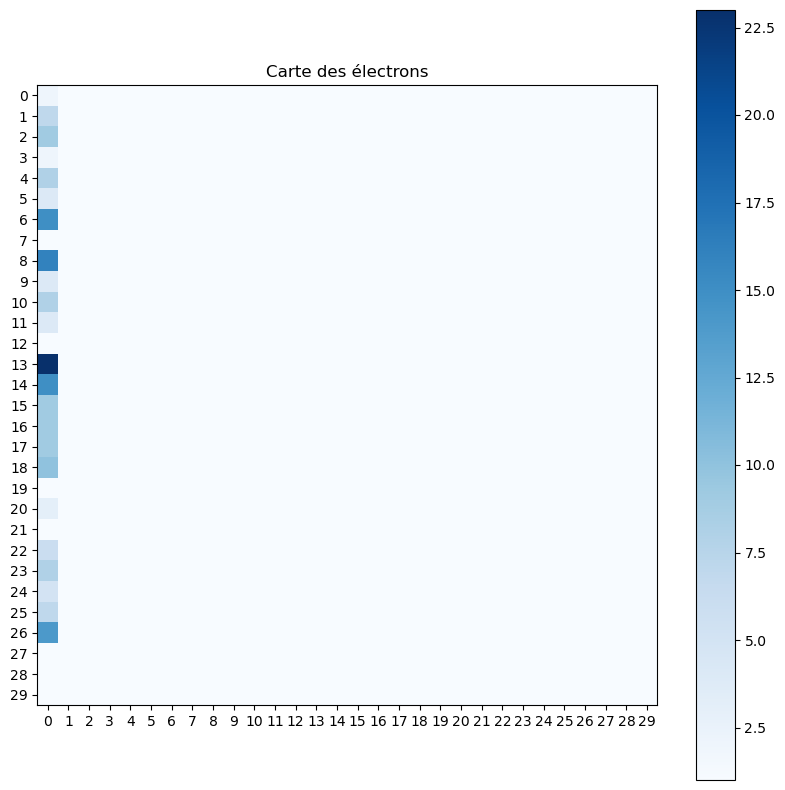

In [43]:
if verbose:
    print(f"Probabilités utilisées: {proj}")
    print(f"Position des électrons : {traces}")
    first_initialisation()
    heatmap(electrons)

In [55]:
def initialise(chemins):
    global y, n_el_initial, sites, traces, electrons, proj
    """Initialise la position des électrons lors des passes suivantes. 
    Utilise la liste des chemins existants."""
    for elec in range(n_el_initial):
        t = np.random.choice(["Début", "Fin"], p = [prob_deb, 1 - prob_deb])
        if t=="Début":
            position = np.random.choice(np.arange(N), p = proj)
            electrons[position,0] += 1
            traces[elec] = [(position,0)]
        else:
            chem = np.random.choice(np.arange(len(chemins)))
            pos_chem = np.random.choice(np.arange(len(chemins[chem])))
            position = chemins[chem][pos_chem]
            electrons[position] += 1
            traces[elec] = [position]

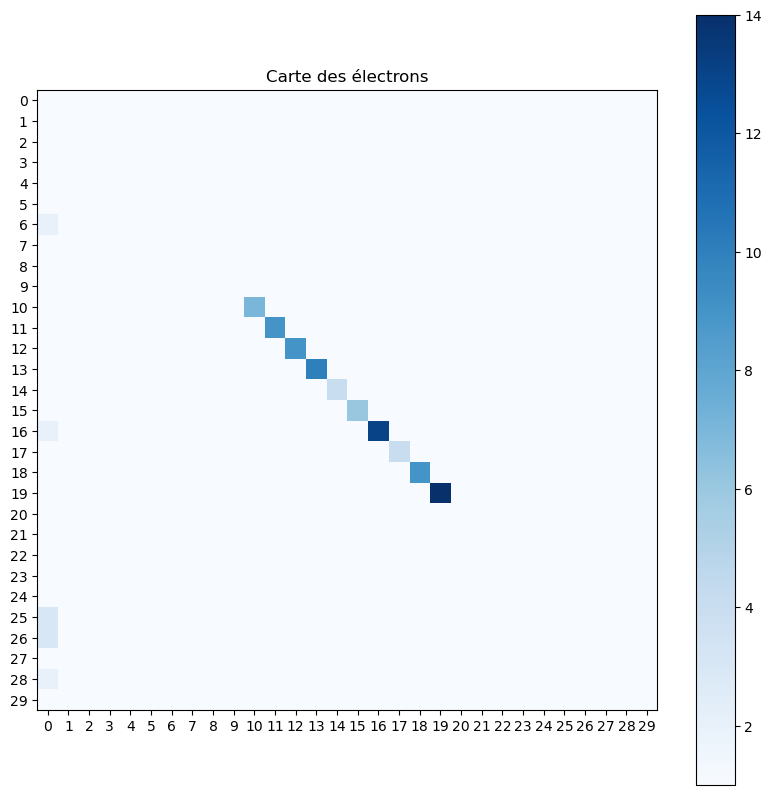

In [59]:
if verbose:
    reinitialise()
    initialise([[(10,10)],[(11,11)],[(12,12)],[(13,13)],[(14,14)],[(15,15)],[(16,16)],[(17,17)],[(18,18)],[(19,19)]])
    heatmap(electrons)

# Probabilités de déplacement

In [67]:
def position_into_reality(i,j):
    return a*(i+z[i,j,0]),a*(j+z[i,j,1])

In [69]:
def distance(i,j,k,l):
    xi,yi = position_into_reality(i,j)
    xj,yj = position_into_reality(k,l)
    return np.sqrt((xi-xj)**2 + (yi-yj)**2)

In [78]:
def calcul_probas(V,i,j):
    droite,gauche,haut,bas = 0.,0.,0.,0.
    phi = 2*1.60217662e-19
    if j<N-1:
        if j+1<N and sites[i,j+1] == 1:
            haut = 3
        if j>0 and sites[i,j-1] == 1:
            bas = 1
        if i+1<N and sites[i+1,j] == 1:
            droite = 1.5
        if i>0 and sites[i-1,j] == 1:
            gauche = 1.5
        sum = droite + gauche + haut + bas
        if sum==0:
            return 0.,0.,0.,0.
        else:
            return droite/sum,gauche/sum,haut/sum,bas/sum
    else:
        return 0.,0.,0.,0.

In [79]:
def pp_probas(V,case):
    droite,gauche,haut,bas = calcul_probas(V,case[0],case[1])
    print(f"Case ({case[0]}, {case[1]}):")
    print(f"\t Probabilité d'aller à droite : {droite}")
    print(f"\t Probabilité d'aller à gauche : {gauche}")
    print(f"\t Probabilité d'aller en haut : {haut}")
    print(f"\t Probabilité d'aller en bas : {bas}")

In [77]:
if verbose:
    pp_probas(30,(8,8))

Case (8, 8):
	 Probabilité d'aller à droite : 0.21428571428571427
	 Probabilité d'aller à gauche : 0.21428571428571427
	 Probabilité d'aller en haut : 0.42857142857142855
	 Probabilité d'aller en bas : 0.14285714285714285


In [84]:
def dico_probas(V,seuil=1e-10):
    """Renvoie un dictionnaire contenant les probabilités de chaque case"""
    dico = {}
    for i in range(N):
        for j in range(N):
            dico[(i,j)] = {}
            if sites[i,j]==1:
                droite,gauche,haut,bas = calcul_probas(V,i,j)
                if droite>seuil:
                    dico[(i,j)][(i+1,j)] = droite
                if gauche>seuil:
                    dico[(i,j)][(i-1,j)] = gauche
                if haut>seuil:
                    dico[(i,j)][(i,j+1)] = haut
                if bas>seuil:
                    dico[(i,j)][(i,j-1)] = bas
    return dico

In [87]:
if verbose:
    print(dico_probas(30))

{(0, 0): {(1, 0): 0.3333333333333333, (0, 1): 0.6666666666666666}, (0, 1): {(1, 1): 0.2727272727272727, (0, 2): 0.5454545454545454, (0, 0): 0.18181818181818182}, (0, 2): {(1, 2): 0.2727272727272727, (0, 3): 0.5454545454545454, (0, 1): 0.18181818181818182}, (0, 3): {(1, 3): 0.2727272727272727, (0, 4): 0.5454545454545454, (0, 2): 0.18181818181818182}, (0, 4): {(1, 4): 0.2727272727272727, (0, 5): 0.5454545454545454, (0, 3): 0.18181818181818182}, (0, 5): {(1, 5): 0.2727272727272727, (0, 6): 0.5454545454545454, (0, 4): 0.18181818181818182}, (0, 6): {(1, 6): 0.2727272727272727, (0, 7): 0.5454545454545454, (0, 5): 0.18181818181818182}, (0, 7): {(1, 7): 0.2727272727272727, (0, 8): 0.5454545454545454, (0, 6): 0.18181818181818182}, (0, 8): {(1, 8): 0.2727272727272727, (0, 9): 0.5454545454545454, (0, 7): 0.18181818181818182}, (0, 9): {(1, 9): 0.2727272727272727, (0, 10): 0.5454545454545454, (0, 8): 0.18181818181818182}, (0, 10): {(1, 10): 0.2727272727272727, (0, 11): 0.5454545454545454, (0, 9): 0

# Réalisation d'une transition

In [96]:
def deplacement(V,elec,probs):
    global electrons,traces
    i,j = traces[elec][-1]
    clefs = list(probs[(i,j)].keys())
    if len(clefs) != 0:
        valeurs = list(probs[(i,j)].values())
        indice = np.random.choice(np.arange(len(clefs)), p = valeurs)
        new = clefs[indice]
        traces[elec].append(new)
        electrons[i,j] -= 1
        electrons[new[0],new[1]] += 1

In [97]:
def transition(V):
    probas = dico_probas(V)
    for k in range(n_el_initial):
        deplacement(V,k,probas)

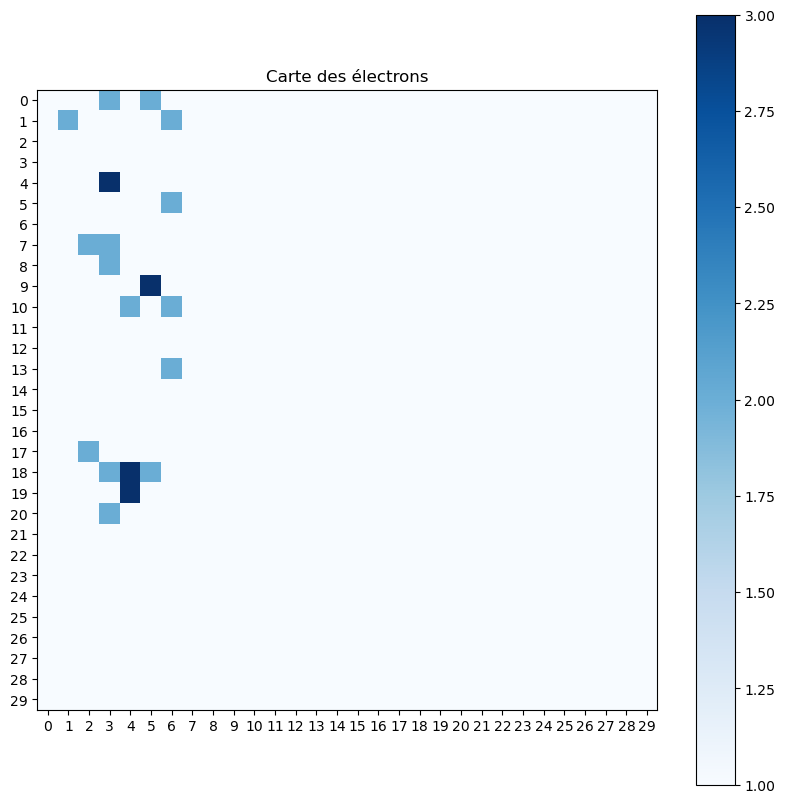

In [ ]:
if verbose:
    #reinitialise()
    #first_initialisation()
    transition(4.)
    heatmap(electrons)

# Réalisation de l'étape

In [122]:
def calcule_intensite(V,chem):
    li = np.array([len(chemin) for chemin in chem])
    res = 1/(np.sum(1/li))
    return V/res

In [124]:
def etape(V, chem, first = False):
    global traces, n_el_initial,N_iterations
    if first:
        first_initialisation()
    else:
        initialise(chem)
    for i in range(N_iterations):
        transition(V)
    liste = [chemin for chemin in traces.values() if chemin[-1][1]==N-1]
    return calcule_intensite(V,liste),liste
    

In [138]:
def simulation(array_V,affiche = True, trace_carac = True):
    reinitialise()
    chem = []
    intense = []
    for (i,V) in enumerate(array_V):
        intensite, chem = etape(V,chem,(i==0))
        intense.append(intensite)
        print(f"Etape {i}, Intensité : {intensite}")
        if affiche:
            heatmap(electrons)
    if trace_carac:
        plt.scatter(array_V,intense)
        plt.xlabel("Tension (V)")
        plt.ylabel("Intensité (A)")
        plt.title("Caractéristique I(V)")
        plt.grid()
        plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


Etape 0, Intensité : 0.0
Etape 1, Intensité : 5.628135672052793
Etape 2, Intensité : 13.543814880564177
Etape 3, Intensité : 38.880108904151776
Etape 4, Intensité : 59.15644470326964
Etape 5, Intensité : 93.68507149793648
Etape 6, Intensité : 169.5430692564192
Etape 7, Intensité : 210.8114303148912
Etape 8, Intensité : 230.0342493308513
Etape 9, Intensité : 256.4782457281695
Etape 10, Intensité : 305.7927751211089
Etape 11, Intensité : 353.5442909244087
Etape 12, Intensité : 422.0949070789133
Etape 13, Intensité : 444.7799037292608
Etape 14, Intensité : 394.2136380048904
Etape 15, Intensité : 463.26106169051434
Etape 16, Intensité : 547.339620068976
Etape 17, Intensité : 598.1615282131232
Etape 18, Intensité : 712.5567052939435
Etape 19, Intensité : 805.2442768514798


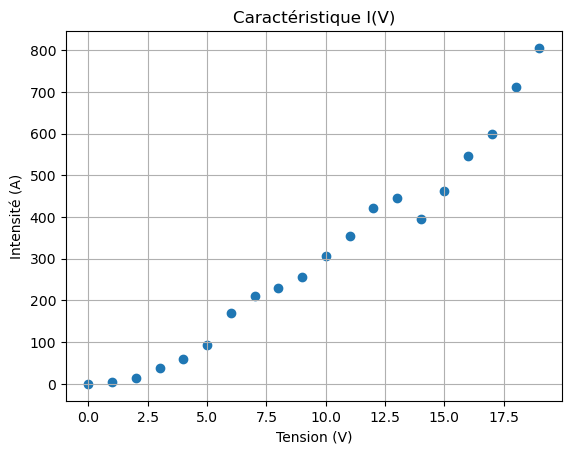

In [139]:
array_V = list(range(0,20))
print(array_V)
simulation(array_V, affiche = False)